In this notebook i'm documenting every step in understanding and visualizing the data for my networking course research. this is so me, my partners, and my professors can see my thought process. 

my first step was opening the three files our professor gave us, and asking gemini, so i could understand what was going on. the csv data contained the raw performance metrics of the commercial site under different timestamps and scenarios. this makes it perfect for the load pattern analysis.

the generate_data.py script was useful was generating different sample data. i can run it in the future, changing certain values like criticality and resource requirements, to adapt it to any type of scenario i wish to analyze. for now, it is redundant. the tex file is also redundant for this notebook.

some useful information i got through the script were **the dependecies and baselines of each service**. i see that the **logging service and api gateway** are by far the most important services to be studied. it was also nice that the ML algorithm was already implemented. what's left for us to do is study the behaviour.

i am curious to see what the output of the script will be if i execute it;

Creating ML target variables...
Created target variables for 10000 records across 15 services

======================================================================
MICROSERVICES LOAD BALANCING DATA GENERATED
======================================================================
Total records: 10000
Date range: 2025-11-25 00:00:00 to 2025-11-30 05:16:45

Services: 15
  - api-gateway: critical priority
  - user-service: high priority
  - product-catalog: high priority
  - order-service: critical priority
  - payment-service: critical priority
  - inventory-service: high priority
  - notification-service: medium priority
  - analytics-service: low priority
  - recommendation-engine: medium priority
  - review-service: low priority
  - cart-service: high priority
  - shipping-service: medium priority
  - search-service: high priority
  - image-service: medium priority
  - logging-service: low priority

Summary Statistics:
  Avg error rate: 1.35%
  Avg latency: 182ms
  Avg P99 latency: 617ms
  Scaling events: 3152
  Unhealthy instances: 38 (0.4%)

Load Balancing Algorithms:
  - round-robin: 2488 (24.9%)
  - least-connections: 2068 (20.7%)
  - weighted-response-time: 1474 (14.7%)
  - random: 1006 (10.1%)
  - ip-hash: 928 (9.3%)
  - ml-predictive: 2036 (20.4%)

File saved: 'microservices_load_data.csv'
======================================================================

**so the script also gives us some statistics right out the gate. but we need to make other scripts to create the deliverables of module 2.**


## 1. setup and data loading

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
#added this for later
from pandas.plotting import autocorrelation_plot

INPUT_FILE = "microservices_load_data.csv"

# plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

def load_data(filepath):
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp']) #converting to python objects
    return df

df = load_data(INPUT_FILE)


i'm making the time series analysis by request volume

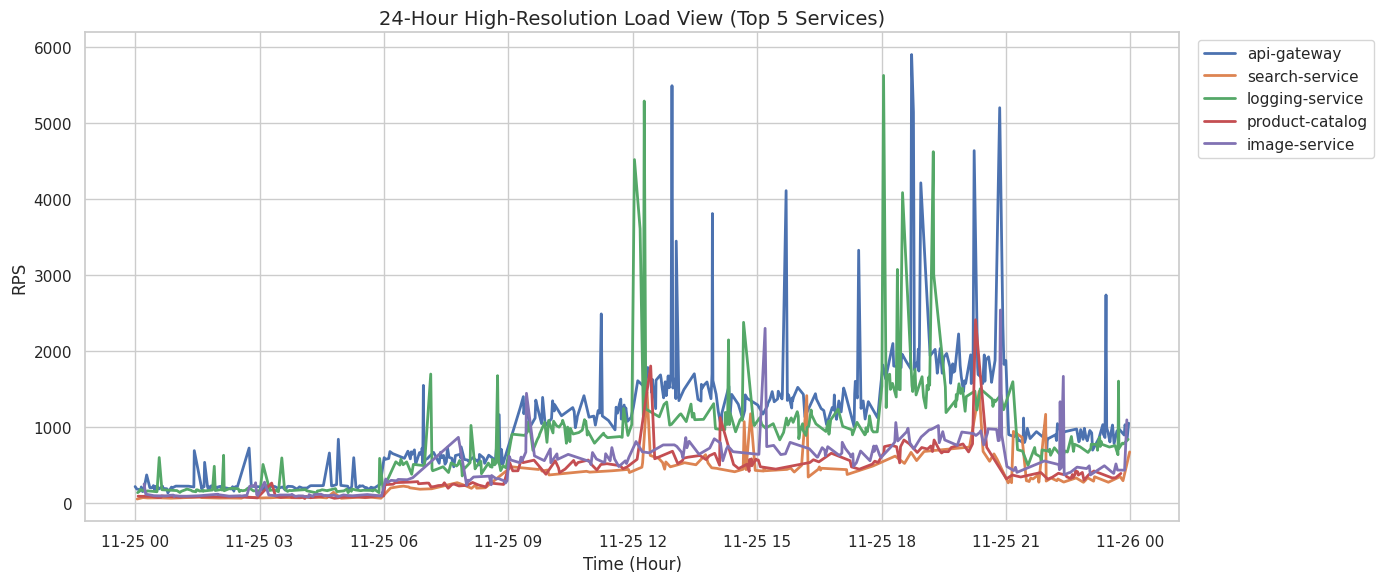

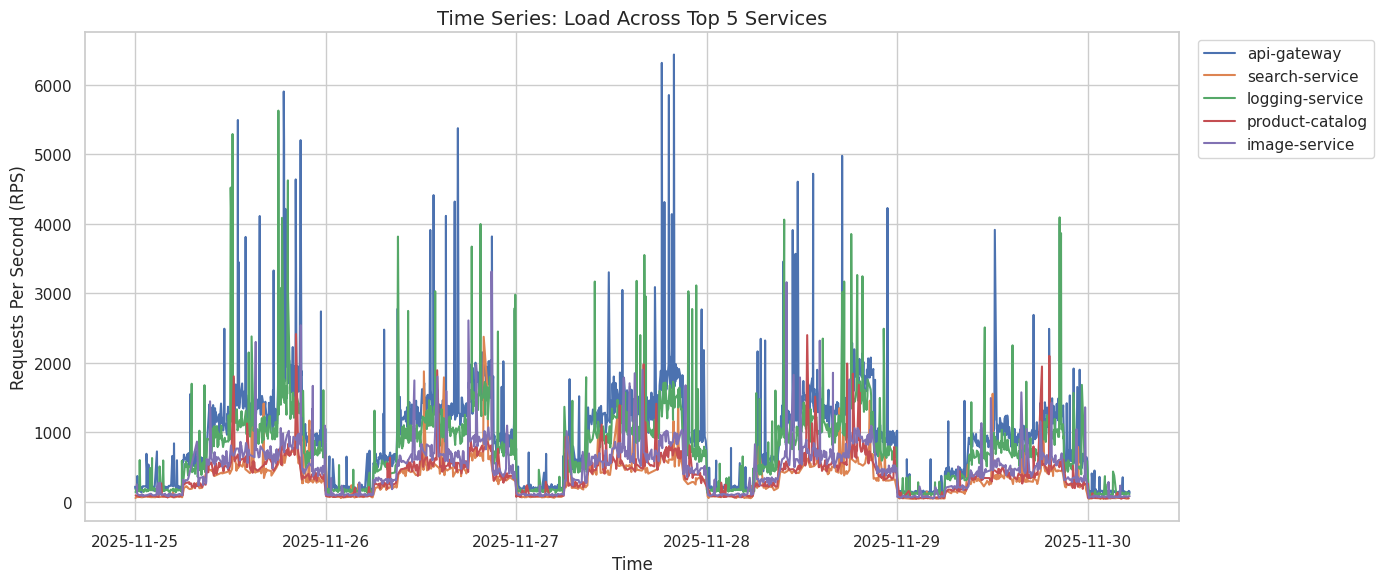

In [2]:
def plot_24h_zoom(df):
    #visualizing the first 24 hours
    end_time = df['timestamp'].min() + pd.Timedelta(hours=24)
    df_24h = df[df['timestamp'] <= end_time]
    
    top_services = df.groupby('service_name')['request_rate_rps'].mean().nlargest(5).index
    
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_24h[df_24h['service_name'].isin(top_services)], 
                 x='timestamp', y='request_rate_rps', hue='service_name', lw=2)
    plt.title('24-Hour High-Resolution Load View (Top 5 Services)')
    plt.ylabel('RPS')
    plt.xlabel('Time (Hour)')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_24h_zoom(df)

#now making the time series for the entire week
def plot_time_series(df):
    top_services = df.groupby('service_name')['request_rate_rps'].mean().nlargest(5).index
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df[df['service_name'].isin(top_services)], 
                 x='timestamp', y='request_rate_rps', hue='service_name', lw=1.5)
    plt.title('Time Series: Load Across Top 5 Services')
    plt.ylabel('Requests Per Second (RPS)')
    plt.xlabel('Time')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_time_series(df)


now i'm visualizing the dependecies in a network graph. asked gemini to whip up the code since the dependencies are already laid out in the script.

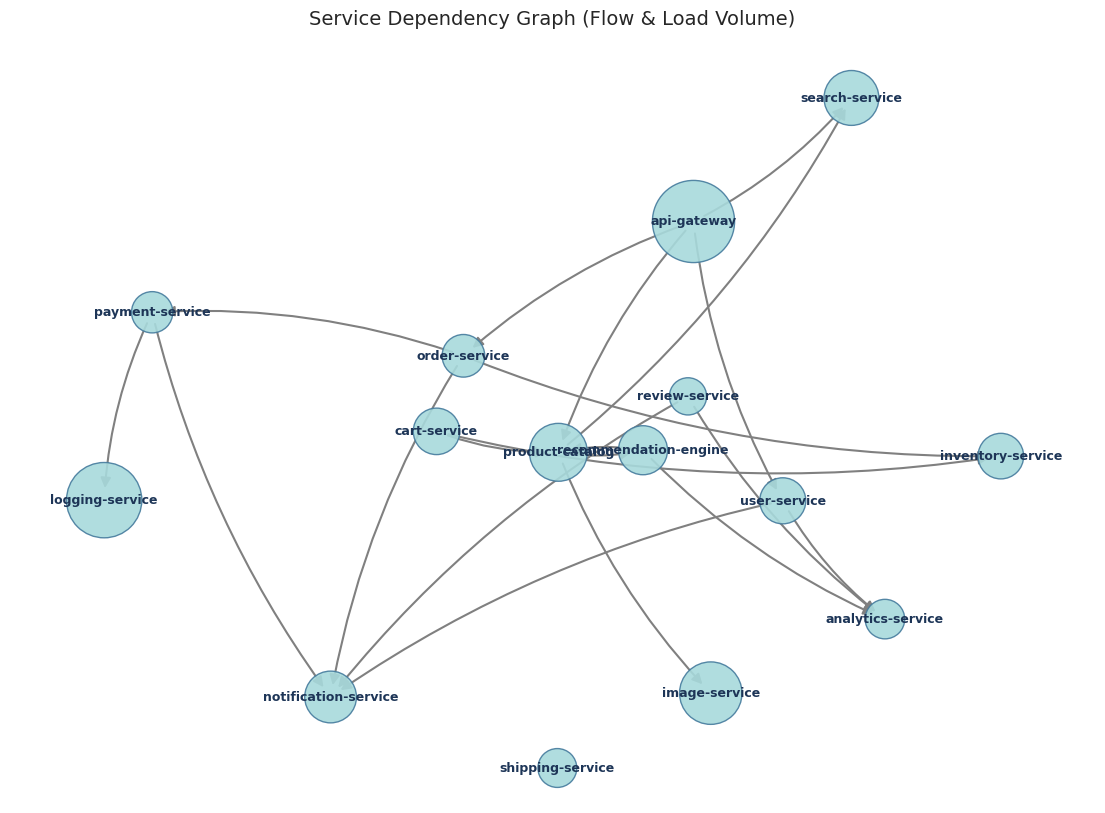

In [3]:

def plot_dependency_graph(df):
    # copied from the script
    dependencies = {
        "api-gateway": ["user-service", "product-catalog", "order-service", "search-service"],
        "order-service": ["payment-service", "inventory-service", "notification-service"],
        "product-catalog": ["search-service", "recommendation-engine", "image-service"],
        "recommendation-engine": ["product-catalog", "analytics-service"],
        "user-service": ["notification-service", "analytics-service"],
        "payment-service": ["notification-service", "logging-service"],
        "review-service": ["notification-service", "analytics-service"],
        "cart-service": ["product-catalog", "inventory-service"],
    }

    G = nx.DiGraph()
    for source, targets in dependencies.items():
        for target in targets:
            G.add_edge(source, target)

    G.add_nodes_from(df['service_name'].unique())

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, seed=42, k=1.2)
    
    # taking the mean rps for each service to also visualizetheir weight in thearchitecture 
    node_sizes = df.groupby('service_name')['request_rate_rps'].mean().reindex(G.nodes).fillna(10)
    norm_sizes = (node_sizes / node_sizes.max()) * 3000 + 500
    
    nx.draw_networkx_nodes(G, pos, node_size=norm_sizes, node_color='#a8dadc', alpha=0.9, edgecolors='#457b9d')
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, width=1.5, arrowsize=15, connectionstyle='arc3,rad=0.1')
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', font_color='#1d3557')
    
    plt.title('Service Dependency Graph (Flow & Load Volume)')
    plt.axis('off')
    plt.show()

plot_dependency_graph(df)



latency analysis. i'm going to take the mean of each percentile of each service and plot it.


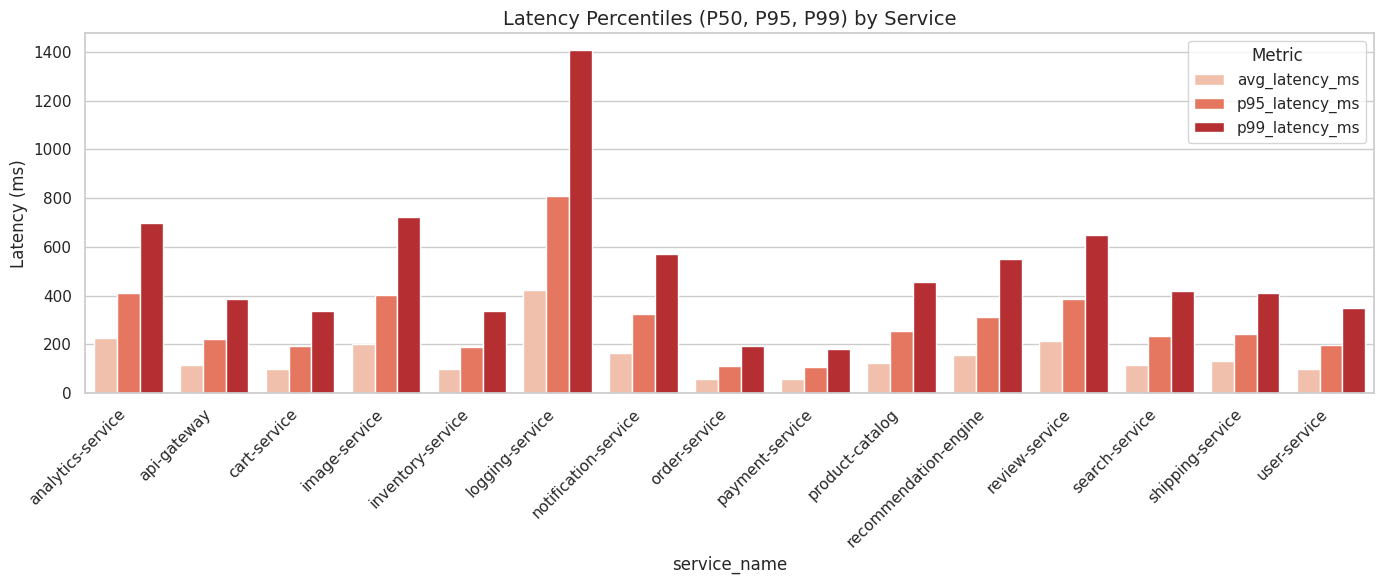

In [4]:

def plot_latency_percentiles(df):
    latency_metrics = df.groupby('service_name')[['avg_latency_ms', 'p95_latency_ms', 'p99_latency_ms']].mean().reset_index()
    latency_melted = latency_metrics.melt(id_vars='service_name', var_name='Metric', value_name='Latency (ms)')
    
    plt.figure(figsize=(14, 6))
    sns.barplot(data=latency_melted, x='service_name', y='Latency (ms)', hue='Metric', palette="Reds")
    plt.title('Latency Percentiles (P50, P95, P99) by Service')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

plot_latency_percentiles(df)



we should now analyze how much each service weighs on system resources. i'm seeing how much each service wighs on the cpu with a heatmap. also learned how to make a 24 hour time series for it, to see the trends.

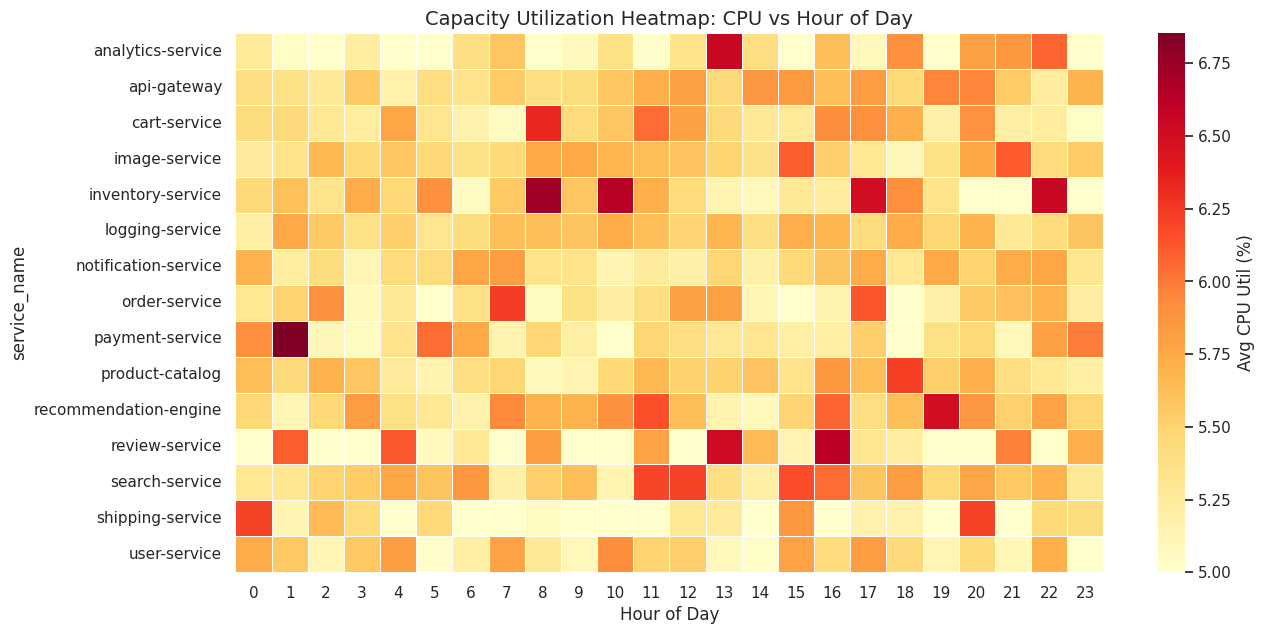

In [ ]:

def plot_heatmaps(df):
    # taking the mean values again
    df['hour_col'] = df['timestamp'].dt.hour
    cpu_heatmap = df.pivot_table(index='service_name', columns='hour_col', values='cpu_utilization', aggfunc='mean')
    
    plt.figure(figsize=(14, 7))
    sns.heatmap(cpu_heatmap, cmap='YlOrRd', cbar_kws={'label': 'Avg CPU Util (%)'}, linewidths=.5)
    plt.title('Capacity Utilization Heatmap: CPU vs Hour of Day')
    plt.xlabel('Hour of Day')
    plt.show()

    # we also need to make a correlation matrix for the services. need to improve on this
    pivot_rps = df.pivot_table(index='timestamp', columns='service_name', values='request_rate_rps').fillna(0)
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot_rps.corr(), cmap='coolwarm', center=0, annot=True, fmt=".2f", square=True, linewidths=.5)
    plt.title('Traffic Correlation Matrix Between Services')
    plt.show()

plot_heatmaps(df)



**failure propagation:** correlation between error rates and cascading risk. (we see the correlation coeff rises non-linearly and significantly, showing there are many dependencies making our system fragile, and a very small windoow of 'tolerable' error)
**strategy comparison:** latency & throughput by LB algo
**cost analysis:** seeing how much cpu is used compared to number of pods, to see how necessary it is to increase cost. future studying might be needed to make a time series so the service cpu util is added up

/tmp/ipykernel_11750/2107789159.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='lb_algorithm', y='avg_latency_ms', estimator=np.mean,
/tmp/ipykernel_11750/2107789159.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='lb_algorithm', y='network_throughput_mbps', estimator=np.mean,


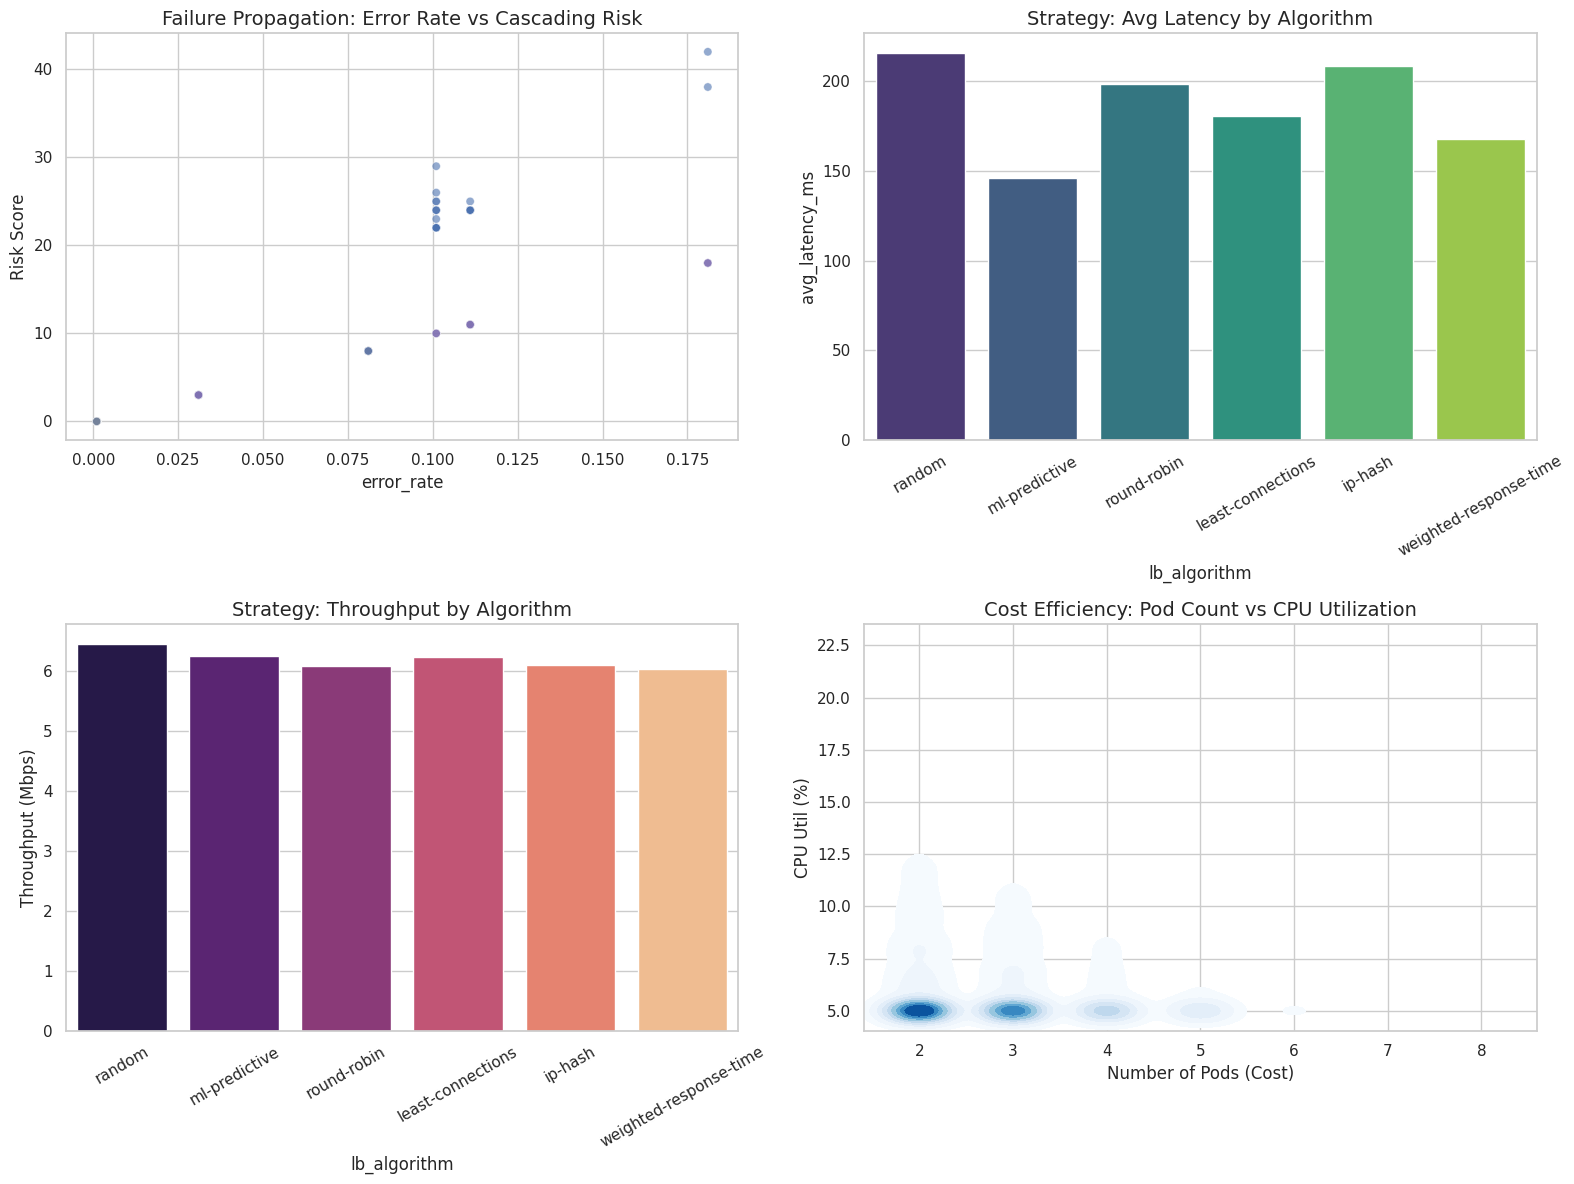

In [13]:

def plot_strategy_analysis(df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # failure risk by error rate
    sns.scatterplot(data=df, x='error_rate', y='cascading_failure_risk', hue='service_name', 
                    alpha=0.6, ax=axes[0, 0], legend=False, palette='deep')
    axes[0, 0].set_title('Failure Propagation: Error Rate vs Cascading Risk')
    axes[0, 0].set_ylabel('Risk Score')
    
    # latency by algo
    sns.barplot(data=df, x='lb_algorithm', y='avg_latency_ms', estimator=np.mean, 
                errorbar=None, palette='viridis', ax=axes[0, 1])
    axes[0, 1].set_title('Strategy: Avg Latency by Algorithm')
    axes[0, 1].tick_params(axis='x', rotation=30)
    
    #throughput by algo
    sns.barplot(data=df, x='lb_algorithm', y='network_throughput_mbps', estimator=np.mean, 
                errorbar=None, palette='magma', ax=axes[1, 0])
    axes[1, 0].set_title('Strategy: Throughput by Algorithm')
    axes[1, 0].tick_params(axis='x', rotation=30)
    axes[1, 0].set_ylabel('Throughput (Mbps)')

    # cpu v pods
    sns.kdeplot(data=df, x='num_pods', y='cpu_utilization', fill=True, cmap="Blues", ax=axes[1, 1])
    axes[1, 1].set_title('Cost Efficiency: Pod Count vs CPU Utilization')
    axes[1, 1].set_xlabel('Number of Pods (Cost)')
    axes[1, 1].set_ylabel('CPU Util (%)')

    plt.tight_layout()
    plt.show()

plot_strategy_analysis(df)


**anomaly detection**
this was a fun one. basically we need to find anomalies in the services, for example in the cpu utilization. setting the threshold statically would be incorrect, so we calculated a z-score z = (value - mean) / sigma. calculating the mean as the baseline, we set an arbitrary  z-value as deviation, like 3. if the a z-score is 3, that means that the value deviates from the mean by 3 sigma. we leave it to python to calculate sigma, the standard deviation. and if a service deviated from the mean by 3 times the standard deviation, we consider that an anomaly


--- DYNAMIC THRESHOLDING (Z-SCORE > 3) ---
Total Anomalies Detected: 312
Top Services with Anomalies:
 service_name
api-gateway        62
logging-service    50
image-service      31
Name: count, dtype: int64


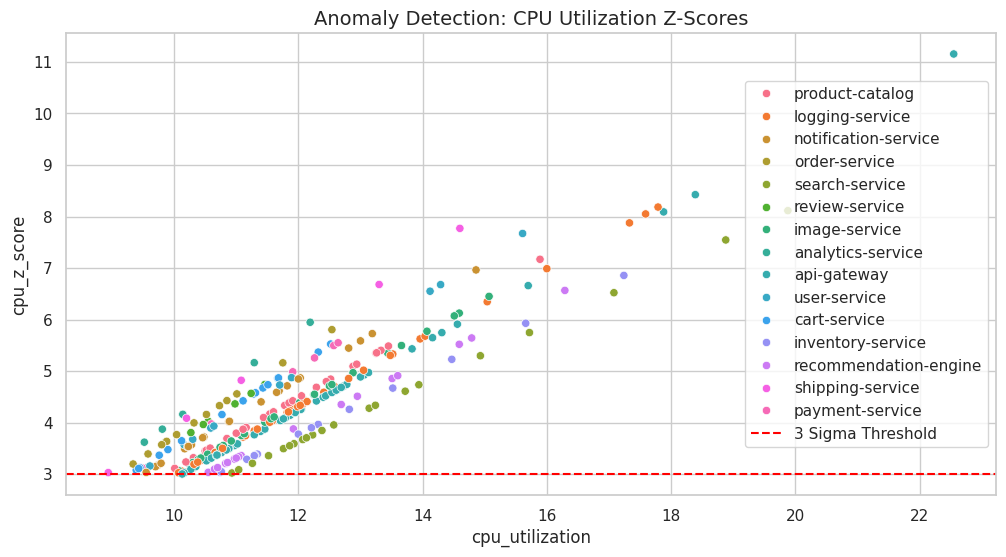

In [14]:

def analyze_anomalies(df):
    # calculate mean and standard devaition for each service
    stats = df.groupby('service_name')['cpu_utilization'].agg(['mean', 'std']).reset_index()
    
    # merge back to calculate z-score: z = (x - mean) / stddeviation
    df_merged = df.merge(stats, on='service_name', suffixes=('', '_stats'))
    df_merged['cpu_z_score'] = (df_merged['cpu_utilization'] - df_merged['mean']) / df_merged['std']
    
    # threshold: z > 3     
    anomalies = df_merged[df_merged['cpu_z_score'] > 3]
    
    print("\n--- DYNAMIC THRESHOLDING (Z-SCORE > 3) ---")
    print(f"Total Anomalies Detected: {len(anomalies)}")
    
    if not anomalies.empty:
        top_anomaly_svc = anomalies['service_name'].value_counts().head(3)
        print("Top Services with Anomalies:\n", top_anomaly_svc)
        
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=anomalies, x='cpu_utilization', y='cpu_z_score', hue='service_name')
        plt.axhline(3, color='red', linestyle='--', label='3 Sigma Threshold')
        plt.title('Anomaly Detection: CPU Utilization Z-Scores')
        plt.legend()
        plt.show()
    
    return anomalies

anomalies = analyze_anomalies(df)



critcality of services based of load size, failure risk, and latency. weights are chosen arbitrarily

In [15]:

def generate_ranking(df):
    avg_stats = df.groupby('service_name')[['request_rate_rps', 'cascading_failure_risk', 'avg_latency_ms']].mean()
    
    # normalize inputs (0 to 1 range)
    norm = (avg_stats - avg_stats.min()) / (avg_stats.max() - avg_stats.min())
    
    # score calculation
    # 40% load, 30% risk factor, 30% latency
    norm['criticality_score'] = (0.4 * norm['request_rate_rps'] + 
                                 0.3 * norm['cascading_failure_risk'] + 
                                 0.3 * norm['avg_latency_ms'])
    
    ranked = norm.sort_values('criticality_score', ascending=False)
    
    print("\n--- SERVICE CRITICALITY RANKING ---")
    print(ranked[['criticality_score']].head(5))

generate_ranking(df)


--- SERVICE CRITICALITY RANKING ---
                 criticality_score
service_name                      
logging-service           0.789928
api-gateway               0.637977
image-service             0.566535
product-catalog           0.502627
search-service            0.463536


a final report identifying actual baseline metrics, and bottlenecks in latency and cpu usage.


In [16]:

def generate_report(df):
    print("MICROSERVICES LOAD PATTERN ANALYSIS REPORT")
    print("==========================================")
    
    # 1. baseline performance
    print(f"\n1. BASELINE METRICS")
    print(f"   - Total Data Points:     {len(df)}")
    print(f"   - Avg Global Latency:    {df['avg_latency_ms'].mean():.2f} ms")
    print(f"   - Avg Global Error Rate: {df['error_rate'].mean()*100:.3f}%")
    print(f"   - Peak Throughput:       {df['network_throughput_mbps'].max():.2f} Mbps")

    # 2. bottlenecks
    print(f"\n2. IDENTIFIED BOTTLENECKS")
    # latency bottlenecks
    high_latency = df[df['avg_latency_ms'] > 200].groupby('service_name').size().sort_values(ascending=False)
    print("   High Latency Services (> 200ms events):")
    if not high_latency.empty:
        for svc, count in high_latency.head(3).items():
            print(f"   - {svc}: {count} events")
    else:
        print("   - None detected.")
        
    # cpu saturation
    cpu_sat = df[df['cpu_utilization'] > 20].groupby('service_name').size().sort_values(ascending=False)
    print("   CPU Saturation Candidates (> 20% util events):")
    if not cpu_sat.empty:
        for svc, count in cpu_sat.head(3).items():
            print(f"   - {svc}: {count} events")
    else:
        print("   - Stable CPU usage observed.")

generate_report(df)

MICROSERVICES LOAD PATTERN ANALYSIS REPORT

1. BASELINE METRICS
   - Total Data Points:     10000
   - Avg Global Latency:    182.17 ms
   - Avg Global Error Rate: 1.352%
   - Peak Throughput:       110.92 Mbps

2. IDENTIFIED BOTTLENECKS
   High Latency Services (> 200ms events):
   - logging-service: 1578 events
   - image-service: 458 events
   - api-gateway: 142 events
   CPU Saturation Candidates (> 20% util events):
   - api-gateway: 1 events


# extra research
this part is all gemini, i wanted to learn other statistical properties of the data i could find. **it won't be taken into account during the research paper**
Advanced Microservices Statistics
**Focus:** Tail Analysis (Kurtosis) and Signal Memory (Autocorrelation)
1. Kurtosis Analysis (The "Spike" Detector)
Standard deviation tells you the spread. Kurtosis tells you about the *extremes*.
High Kurtosis = The service runs fine usually, but fails **violently** when it does (fat tails).



--- KURTOSIS RANKING ---
High Positive = Frequent Extreme Outliers (Spiky)
Negative = Flat distribution (Uniform/Stable)
             service_name  latency_kurtosis
10  recommendation-engine         25.562449
9         product-catalog         21.334995
2            cart-service         20.024387
5         logging-service         10.514267
3           image-service         10.231988


/tmp/ipykernel_11750/948751782.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=kurtosis_df, x='service_name', y='latency_kurtosis', palette="magma")


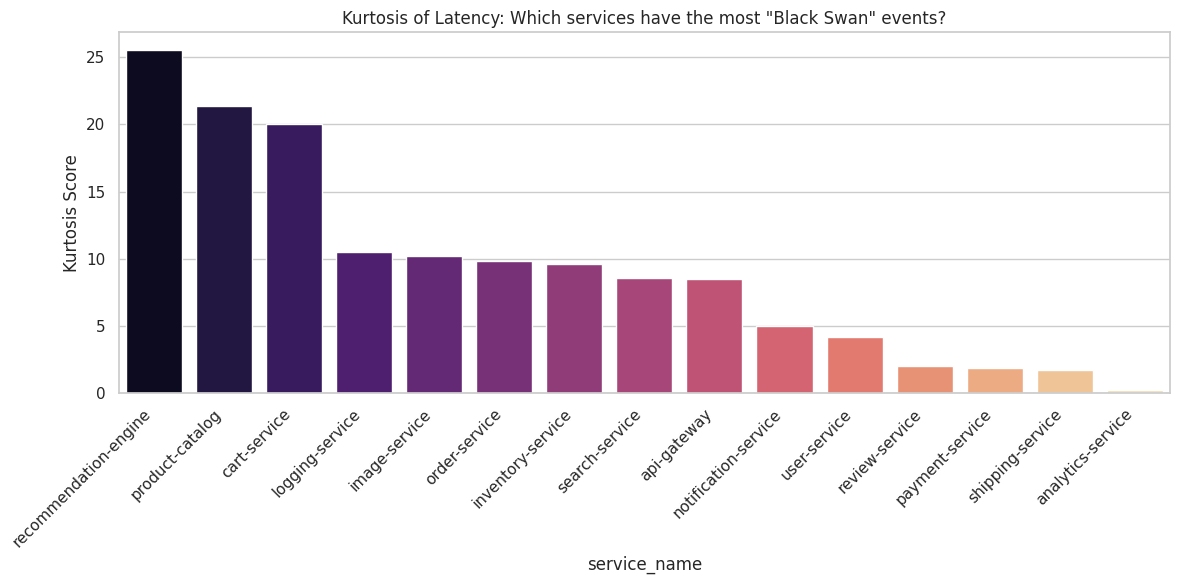

In [17]:
INPUT_FILE = "microservices_load_data.csv"
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def load_data(filepath):
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

df = load_data(INPUT_FILE)
def plot_kurtosis(df):
    # Calculate Fisher Kurtosis (Normal distribution = 0)
    kurtosis_df = df.groupby('service_name')['avg_latency_ms'].apply(lambda x: x.kurt()).reset_index()
    kurtosis_df.columns = ['service_name', 'latency_kurtosis']
    kurtosis_df = kurtosis_df.sort_values('latency_kurtosis', ascending=False)
    
    print("\n--- KURTOSIS RANKING ---")
    print("High Positive = Frequent Extreme Outliers (Spiky)")
    print("Negative = Flat distribution (Uniform/Stable)")
    print(kurtosis_df.head())

    plt.figure(figsize=(12, 6))
    sns.barplot(data=kurtosis_df, x='service_name', y='latency_kurtosis', palette="magma")
    plt.title('Kurtosis of Latency: Which services have the most "Black Swan" events?')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Kurtosis Score')
    plt.tight_layout()
    plt.show()

plot_kurtosis(df)



2. Autocorrelation (Signal Memory)
Can we predict the future based on the past?
We take the top service and check if its traffic correlates with itself at different time lags.


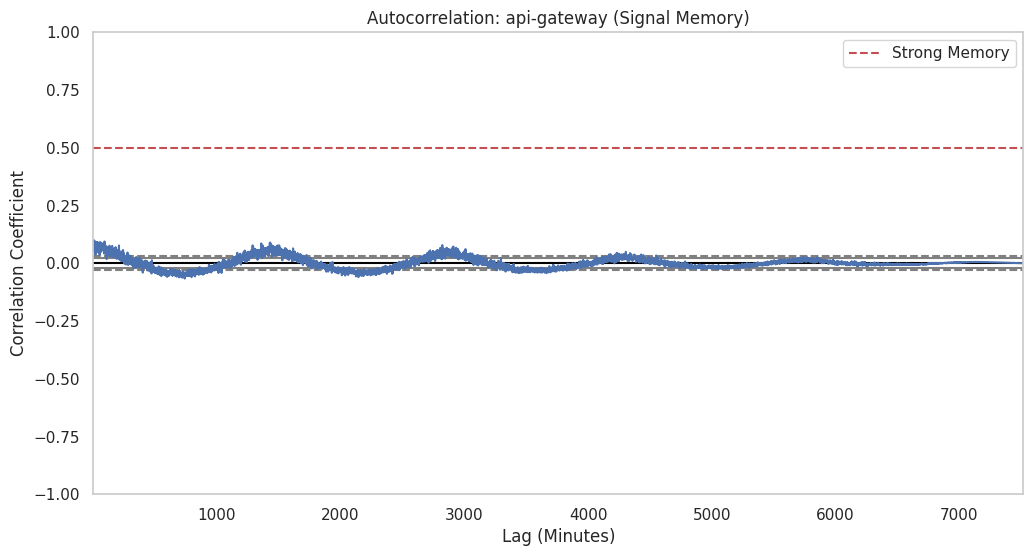


--- AUTOCORRELATION ANALYSIS for api-gateway ---
High peaks at specific lags indicate periodicity (Seasonality).
Slow decay (staying above 0 for long time) indicates strong trend/inertia.


In [18]:

def plot_autocorrelation(df):
    # Select the busiest service
    top_service = df.groupby('service_name')['request_rate_rps'].sum().idxmax()
    service_data = df[df['service_name'] == top_service].sort_values('timestamp')
    
    # Resample to 1-minute intervals to regularize the signal
    ts_data = service_data.set_index('timestamp')['request_rate_rps'].resample('1min').mean().fillna(0)
    
    plt.figure(figsize=(12, 6))
    autocorrelation_plot(ts_data)
    plt.title(f'Autocorrelation: {top_service} (Signal Memory)')
    plt.xlabel('Lag (Minutes)')
    plt.ylabel('Correlation Coefficient')
    
    # Add EE context lines
    plt.axhline(y=0.5, color='r', linestyle='--', label='Strong Memory')
    plt.legend()
    plt.show()
    
    print(f"\n--- AUTOCORRELATION ANALYSIS for {top_service} ---")
    print("High peaks at specific lags indicate periodicity (Seasonality).")
    print("Slow decay (staying above 0 for long time) indicates strong trend/inertia.")

plot_autocorrelation(df)